# Replicating Examples from "The Effect"

This notebook replicates code examples from Nick Huntington-Klein's book on causal inference, [The Effect](https://theeffectbook.net/). 

In [63]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pyfixest as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Chapter 4: Describing Relationships

In [67]:
from causaldata import Mroz

# Read in data
dt = Mroz.load_pandas().data
# Keep just working women
dt = dt[dt['lfp'] == True]
# Create unlogged earnings
dt.loc[:,'earn'] = dt['lwg'].apply('exp')

# 5. Run multiple linear regression models by succesively adding controls
fixest = pf.Fixest(dt)
fixest.feols("lwg ~ csw(inc, wc, k5)", vcov = "iid")
fixest.etable()

C:\Users\alexa\AppData\Local\Temp\ipykernel_22772\1873377555.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt.loc[:,'earn'] = dt['lwg'].apply('exp')


fml           lwg~inc        lwg~inc+wc               lwg~inc+wc+k5         \
Coefficient Intercept    inc  Intercept    inc     wc     Intercept    inc   
Estimate        1.007  0.010      0.972  0.005  0.342         0.982  0.005   
Std. Error      0.071  0.003      0.070  0.003  0.075         0.071  0.003   
t value        14.180  2.947     13.909  1.640  4.595        13.819  1.590   
Pr(>|t|)        0.000  0.003      0.000  0.102  0.000         0.000  0.113   
2.5 %           0.868  0.003      0.834 -0.001  0.196         0.843 -0.001   
97.5 %          1.147  0.016      1.109  0.012  0.489         1.122  0.012   

fml                        
Coefficient     wc     k5  
Estimate     0.349 -0.072  
Std. Error   0.075  0.087  
t value      4.656 -0.825  
Pr(>|t|)     0.000  0.410  
2.5 %        0.202 -0.243  
97.5 %       0.497  0.099

In [68]:
# to only get the coefficients for inc
fixest.etable().xs(key = "inc", level = 1, axis = 1)

fml,lwg~inc,lwg~inc+wc,lwg~inc+wc+k5
Estimate,0.010,0.005,0.005
Std. Error,0.003,0.003,0.003
t value,2.947,1.640,1.590
Pr(>|t|),0.003,0.102,0.113
2.5 %,0.003,-0.001,-0.001
97.5 %,0.016,0.012,0.012


## Chapter 13: Regression

### Example 1

In [72]:
from causaldata import restaurant_inspections

res = restaurant_inspections.load_pandas().data
res.inspection_score = res.inspection_score.astype(float)
res.NumberofLocations = res.NumberofLocations.astype(float)
res.dtypes

fixest = pf.Fixest(res)
fixest.feols("inspection_score ~ NumberofLocations")
fixest.etable()

fml         inspection_score~NumberofLocations                  
Coefficient                          Intercept NumberofLocations
Estimate                                94.866            -0.019
Std. Error                               0.046             0.000
t value                               2049.047           -43.321
Pr(>|t|)                                 0.000             0.000
2.5 %                                   94.775            -0.020
97.5 %                                  94.956            -0.018

### Example 2

In [98]:
df = restaurant_inspections.load_pandas().data
fixest = pf.Fixest(df)

fixest.feols("inspection_score ~ NumberofLocations + I(NumberofLocations^2) + Year")
fixest.feols("inspection_score ~ NumberofLocations*Weekend + Year")

pd.set_option("display.max_colwidth", 1)
fixest.summary()

###

Model:  OLS
Dep. var.:  inspection_score
Inference:  iid
Observations:  27178

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:-----------------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept              |    225.504 |       12.409 |    18.172 |      0.000 | 201.181 |  249.827 |
| NumberofLocations      |     -0.075 |        0.019 |    -4.041 |      0.000 |  -0.111 |   -0.039 |
| I(NumberofLocations^2) |      0.056 |        0.019 |     3.009 |      0.003 |   0.020 |    0.093 |
| Year                   |     -0.065 |        0.006 |   -10.527 |      0.000 |  -0.077 |   -0.053 |
---
RMSE: 6.038  Adj. R2: 0.069  Adj. R2 Within: 0.069
###

Model:  OLS
Dep. var.:  inspection_score
Inference:  iid
Observations:  27178

| Coefficient               |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------------------|-----------:|-------------:|----------

### Example 3: HC Standard Errors

In [78]:
fixest = pf.Fixest(df)
fixest.feols('inspection_score ~ Year + Weekend', vcov = "HC3").summary()

###

Model:  OLS
Dep. var.:  inspection_score
Inference:  HC3
Observations:  27178

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |    185.380 |       12.150 |    15.257 |      0.000 | 161.564 |  209.196 |
| Year          |     -0.046 |        0.006 |    -7.551 |      0.000 |  -0.057 |   -0.034 |
| Weekend       |      2.057 |        0.353 |     5.829 |      0.000 |   1.365 |    2.749 |
---
RMSE: 6.248  Adj. R2: 0.003  Adj. R2 Within: 0.003


### Example 4: Clustered Standard Errors

In [79]:
fixest = pf.Fixest(df)
fixest.feols('inspection_score ~ Year + Weekend', vcov = {"CRV1":"Weekend"}).summary()

###

Model:  OLS
Dep. var.:  inspection_score
Inference:  {'CRV1': 'Weekend'}
Observations:  27178

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |    185.380 |        3.264 |    56.789 |      0.011 | 143.903 |  226.857 |
| Year          |     -0.046 |        0.002 |   -28.108 |      0.023 |  -0.066 |   -0.025 |
| Weekend       |      2.057 |        0.001 |  1468.257 |      0.000 |   2.039 |    2.075 |
---
RMSE: 6.248  Adj. R2: 0.003  Adj. R2 Within: 0.003


### Example 5: Bootstrap Inference 

In [83]:
fixest = pf.Fixest(df)
fixest.feols('inspection_score ~ Year + Weekend').wildboottest(B = 999, param = "Year")


,param,t value,Pr(>|t|)
fml,,,
inspection_score~Year+Weekend,Year,[-7.5523300180667245],0.0


## Chapter 16: Fixed Effects

### Example 1

tba

### Example 2

In [100]:
from causaldata import gapminder
gm = gapminder.load_pandas().data
gm['logGDPpercap'] = gm['gdpPercap'].apply('log')

fixest = pf.Fixest(gm)
fixest.feols("lifeExp ~ C(country) + np.log(gdpPercap)")
fixest.tidy().head()

Estimate  \
fml                                  Coefficient                                   
lifeExp~C(country)+np.log(gdpPercap) Intercept                        -27.773459   
                                     C(country)[T.Albania]             17.782625   
                                     C(country)[T.Algeria]             5.241055    
                                     C(country)[T.Angola]             -13.907122   
                                     C(country)[T.Argentina]           8.132158    
...                                                                          ...   
                                     C(country)[T.West Bank and Gaza]  8.657483    
                                     C(country)[T.Yemen, Rep.]         3.484655    
                                     C(country)[T.Zambia]              3.439994    
                                     C(country)[T.Zimbabwe]            17.592362   
                                     np.log(gdpPercap)                 9.768959    

                                                                       Std. Error  \
fml                                  Coefficient                                    
lifeExp~C(country)+np.log(gdpPercap) Intercept                         2.500533     
                                     C(country)[T.Albania]             2.195160     
                                     C(country)[T.Algeria]             2.214496     
                                     C(country)[T.Angola]              2.201727     
                                     C(country)[T.Argentina]           2.272781     
...                                                                         ...     
                                     C(country)[T.West Bank and Gaza]  2.201015     
                                     C(country)[T.Yemen, Rep.]         2.165652     
                                     C(country)[T.Zambia]              2.163938     
                                     C(country)[T.Zimbabwe]            2.159680     
                                     np.log(gdpPercap)                 0.296534     

                                                                         t value  \
fml                                  Coefficient                                   
lifeExp~C(country)+np.log(gdpPercap) Intercept                        -11.107015   
                                     C(country)[T.Albania]             8.100835    
                                     C(country)[T.Algeria]             2.366704    
                                     C(country)[T.Angola]             -6.316460    
                                     C(country)[T.Argentina]           3.578065    
...                                                                         ...    
                                     C(country)[T.West Bank and Gaza]  3.933405    
                                     C(country)[T.Yemen, Rep.]         1.609056    
                                     C(country)[T.Zambia]              1.589692    
                                     C(country)[T.Zimbabwe]            8.145821    
                                     np.log(gdpPercap)                 32.943815   

                                                                           Pr(>|t|)  \
fml                                  Coefficient                                      
lifeExp~C(country)+np.log(gdpPercap) Intercept                         0.000000e+00   
                                     C(country)[T.Albania]             1.110223e-15   
                                     C(country)[T.Algeria]             1.806875e-02   
                                     C(country)[T.Angola]              3.481857e-10   
                                     C(country)[T.Argentina]           3.567229e-04   
...                                                                             ...   
                                     C(country)[T.West Bank and Gaza]  8.742297e-05 

### Example 3: TWFE

In [86]:
# Set our individual and time (index) for our data
fixest = pf.Fixest(gm)
fixest.feols("lifeExp ~ np.log(gdpPercap) | country + year")
fixest.summary()

###

Model:  OLS
Dep. var.:  lifeExp
Fixed effects:  country+year
Inference:  {'CRV1': 'country'}
Observations:  1704

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:------------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| np.log(gdpPercap) |      1.450 |        0.677 |     2.141 |      0.034 |   0.111 |    2.788 |
---
RMSE: 3.267  Adj. R2: 0.018  Adj. R2 Within: 0.018


## Chapter 18: Difference-in-Differences

### Example 1

In [87]:
from causaldata import organ_donations

od = organ_donations.load_pandas().data

# Create Treatment Variable
od['California'] = od['State'] == 'California'
od['After'] = od['Quarter_Num'] > 3
od['Treated'] = 1*(od['California'] & od['After'])

fixest = pf.Fixest(od)
fixest.feols("Rate ~ Treated | State + Quarter")
fixest.summary()

###

Model:  OLS
Dep. var.:  Rate
Fixed effects:  State+Quarter
Inference:  {'CRV1': 'State'}
Observations:  162

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Treated       |     -0.022 |        0.006 |    -3.733 |      0.001 |  -0.035 |   -0.010 |
---
RMSE: 0.022  Adj. R2: 0.003  Adj. R2 Within: 0.003


### Example 3: Dynamic Treatment Effect

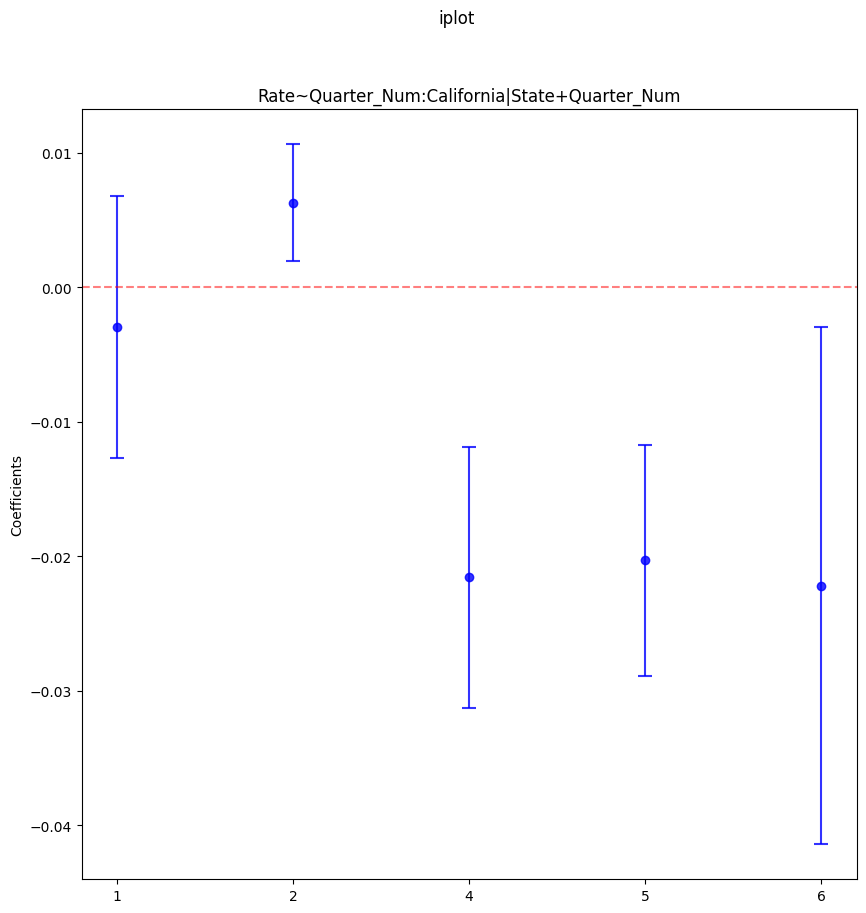

In [91]:
import matplotlib as plt
from causaldata import organ_donations
od = organ_donations.load_pandas().data

# Create Treatment Variable
od['California'] = od['State'] == 'California'
od["Quarter_Num"] = pd.Categorical(od.Quarter_Num)
od["California"] = od.California.astype(float)

fixest = pf.Fixest(od)
fixest.feols("Rate ~ i(Quarter_Num, California, ref = 3) | State + Quarter_Num")
fixest.iplot(yintercept = 0)